# **Drifting assemblies in networks of binary neurons**
Yaroslav Felipe Kalle Kossio, Sven Goedeke, Christian Klos, and Raoul-Martin Memmesheimer

*Neural Network Dynamics and Computation, Institute of Genetics, University of Bonn, Germany.*

---

This notebook contains example code to create a network of binary neurons with three drifting assemblies (see corresponding section and Supplementary Fig. 6 in the manuscript). To illustrate assembly drift the simulation time is set to 250 minutes during which first switches of neurons between the assemblies can be observed.

Parameter | Symbol in the paper | Explanation
--- | --- | ---
`steps` | - | Number of simulation steps
`step_time` | - | Length of step in seconds
`N` | $N_\text{E}$ | Number of excitatory neurons
`bkg` | $p_\text{sp}$ | Spontaneous spike probability of a neuron
`act_threshold` | $\theta$ | Spike threshold
`w_max` | $w_\text{max}$ | Maximum strength of synapse
`eta` | $\eta_\text{strong}$ | Learning rate for strong synapse
`cutoff_u` | $w_\text{th,int}$  | Weak synapse cutoff for interior neurons
`cutoff_s` | $w_\text{th,peri}$  | Weak synapse cutoff for periphery neurons
`llrate_u` | - | $\eta_\text{weak,int}/\eta_\text{strong}$
`llrate_s` | - | $\eta_\text{weak,peri}/\eta_\text{strong}$
`sampling_interval` | - | Number of steps between samples of weight matrix
`record_steps` | -| Number of steps the activity of neurons is recorded

In [3]:
steps = int(1e6)
sampling_interval = int(1e4)
record_steps = int(1e3)

N = 72
w_max = 0.0769

cutoff_u = 0.05 * w_max
cutoff_s = 0.1 * w_max
llrate_u = 0.13
llrate_s = 0.02

bkg = 0.004
act_threshold = 0.1
act_threshold_inh = 0.05
eta = 0.03
step_time = 0.015

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy.ma import masked_array
from tqdm import tqdm
import bct

In [5]:
def zero_diag(A):   
    i = np.arange(A.shape[0])
    A[i,i] = 0
    return A

def norm_rows(A):
    B = A.sum(axis = 1)
    B = np.tile(B,(A.shape[1],1))
    return np.divide(A,B.transpose())

def norm_cols(A):
    B = A.sum(axis = 0)
    B = np.tile(B,(A.shape[0],1))
    return np.divide(A,B)

def stable_unstable_masks(N, stable_neurons = None):
    # Create masks for connections between periphery and interior neurons.
    if stable_neurons is None:
        ss_mask = np.zeros((N,N), dtype=bool)
        su_mask = ss_mask
        uu_mask = np.logical_not(su_mask)
        
    else:      
        s_neurons = np.hstack(stable_neurons) 

        ss_mask = np.zeros((N,N), dtype=bool)
        ss_mask[np.ix_(s_neurons,s_neurons)] = 1

        su_mask = np.zeros((N,N), dtype=bool)
        su_mask[s_neurons,:] = 1
        su_mask[:,s_neurons] = 1
        su_mask = np.logical_xor(su_mask, ss_mask)

        uu_mask = np.logical_not(su_mask + ss_mask)

    return ss_mask, uu_mask, su_mask

def init_clusters(N, C):
    #Create for `N` excitatory neurons an initial excitatory-to-excitatory
    #connectivity matrix with `C` clusters.
    #If `C` is zero, random connectivity is initiated.
    if C == 0:
        W = np.random.rand(N,N)
    else:
        W = np.zeros((N,N))
        n = N//C
        for i in range(C):
            start = n*i
            end = n*(i+1) if i<C-1 else None
            W[start:end,start:end] = 1
            
    W = zero_diag(W)
    W = norm_cols(W)
    W = norm_rows(W)
    
    return W

def cluster(W, L0=None):
    #L0 - initial community affiliation
    try:
        (L, q) = bct.community_louvain(W.copy(), 1, L0)
        
    except bct.BCTParamError:
        return None, None, None, None
        
    else:
        num_clusters = L.max() # number of clusters
        sorted_ind = np.argsort(L) # index of neurons sorted by clusters

        clusters = [] # arrays of neuron indexes belonging to different clusters
        for i in range(num_clusters):
            clusters.append(np.where(L==i+1)[0]) 

        return L, sorted_ind, num_clusters, clusters

In [6]:
x_e = np.zeros(N)
t_i = 0
x_av = np.zeros(N)

In [7]:
# weight matrix initialization
W = init_clusters(N,3)

In [8]:
stable_per_cluster = [4,4,4] # Number of stably coding periphery neurons per cluster

L, sorted_ind, num_clusters, clusters = cluster(W.copy())
#Randomly choosing stable neurons
stable_neurons = []
for i in range(num_clusters):
    stable_neurons.append(np.random.choice(clusters[i], size = stable_per_cluster[i], replace = False))
stable_neurons = np.array(stable_neurons)

ss_mask, uu_mask, su_mask = stable_unstable_masks(N, stable_neurons)

In [10]:
Ws = []
record_act = False
activities = []

for step in tqdm(range(steps)):
    
    x_e_temp = W@x_e - t_i - act_threshold + (1+act_threshold)*np.random.binomial(1, bkg, (N))
    t_i = np.heaviside(x_e.sum()/N - act_threshold_inh - t_i,0)
    x_e = np.heaviside(x_e_temp,0)
    
    x_av = (step*x_av + x_e) / (step  + 1)
    dW = np.outer((x_e - x_av),(x_e - x_av))

    dW[(W < cutoff_u) & uu_mask] *= llrate_u
    dW[(W < cutoff_s) & su_mask] *= llrate_s

    W[uu_mask] += eta*dW[uu_mask]
    W[su_mask] += eta*dW[su_mask]
    W[ss_mask] = 0.
    W[W<0] = 0.
    W[W>w_max] = w_max

    # Normalization
    W = zero_diag(W)
    W = norm_cols(W)
    W = norm_rows(W)
    
    if record_act:
        if record_step < record_steps:
            act[:-1,record_step] = x_e
            act[-1, record_step] = t_i
            record_step += 1
        else:
            record_act = False
            activities.append(act.copy())
    
    if step % sampling_interval == 0:
        Ws.append(W.copy())
        record_act = True
        act = np.zeros((N+1,record_steps))
        record_step = 0

100%|██████████| 1000000/1000000 [03:56<00:00, 4234.41it/s]


## Figure

In [11]:
samples = np.linspace(0,len(Ws)-1,3,dtype=int) #sample matrices to plot
sampling_interval_hours = sampling_interval * step_time / 3600
sample_times_hours = samples * sampling_interval_hours

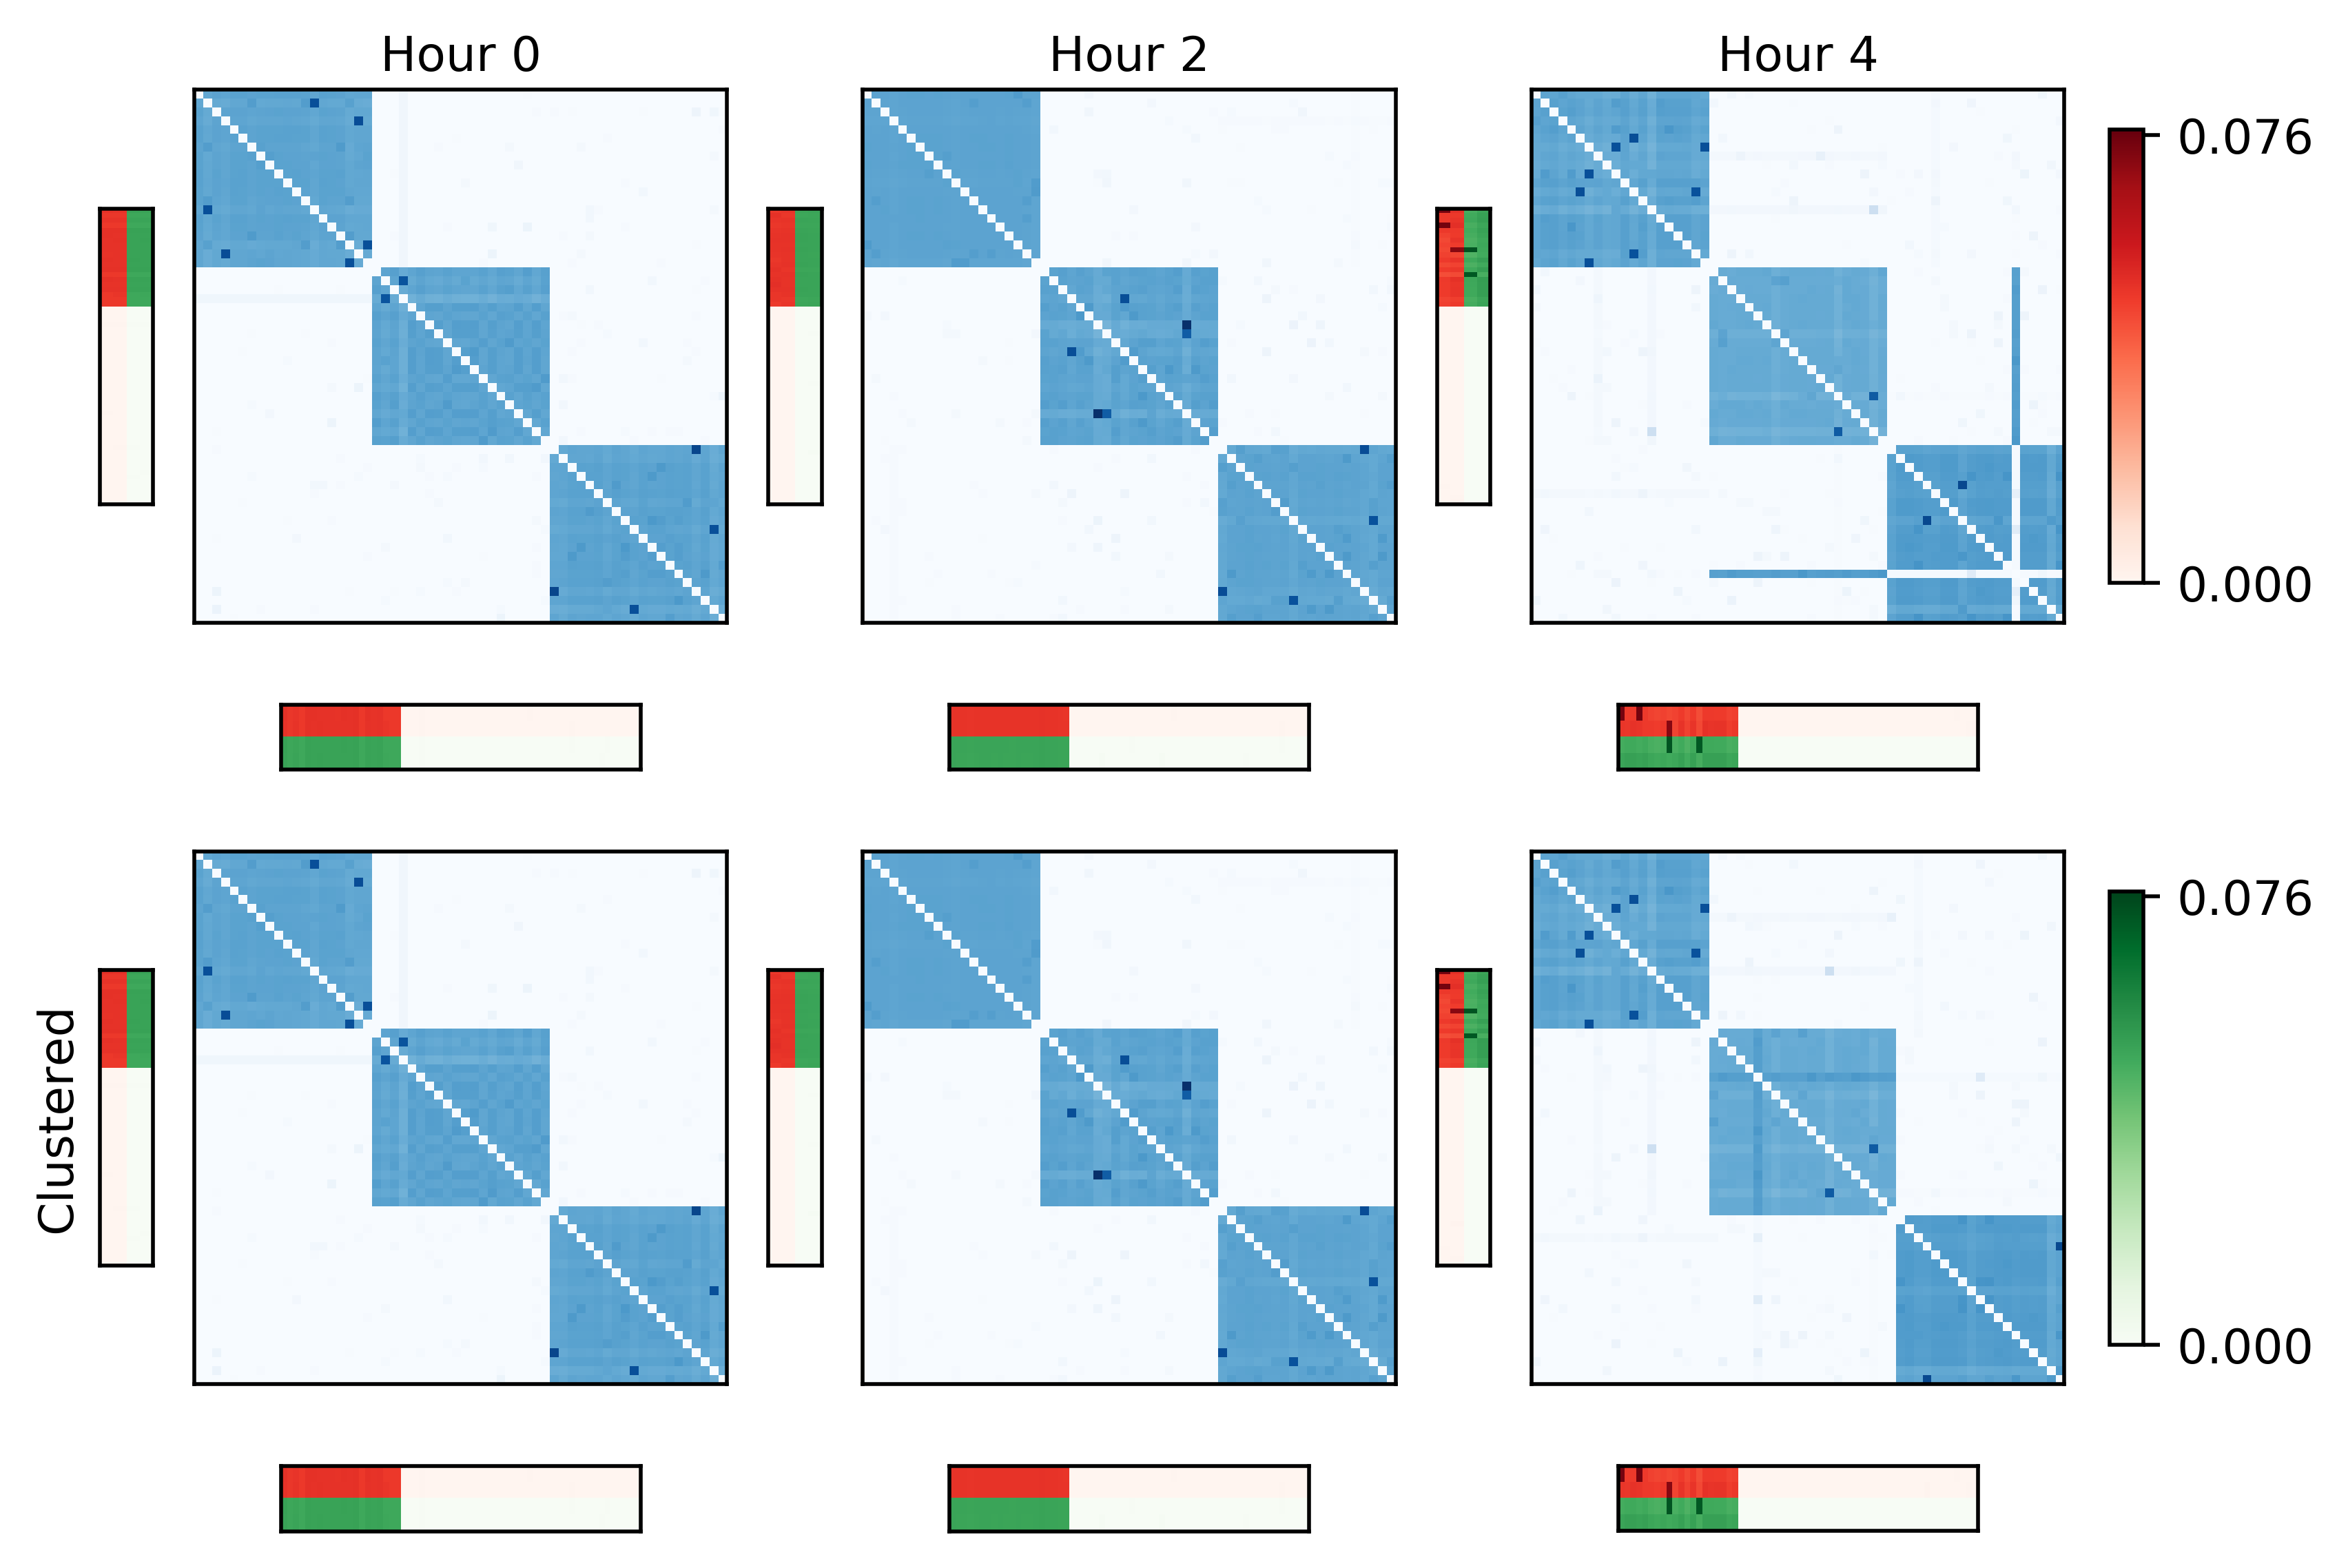

In [12]:
aspect=0.37
width_ratios = [0.1,1]
height_ratios = [1,0.1]
gs_kw = dict(width_ratios=width_ratios*3, height_ratios=height_ratios*2, hspace=0.05, wspace=0.05)
fig, axs = plt.subplots(4,6, figsize=(6.7,4.5), sharex='col',  sharey= 'row', gridspec_kw = gs_kw, dpi=500, constrained_layout=True)

L, sorted_ind, _, _ = cluster(Ws[samples[0]].copy())
# Removing stably coding neurons from the first cluster
sorted_ind_unst = sorted_ind[~np.in1d(sorted_ind,stable_neurons.flatten())]

for i, sample in enumerate(samples):
    unst2unst = Ws[sample][sorted_ind_unst,:][:,sorted_ind_unst]
    st2unst = Ws[sample][sorted_ind_unst,:][:,stable_neurons[0]]
    unst2st = Ws[sample][stable_neurons[0],:][:,sorted_ind_unst]

    mask = np.ones(unst2st.shape, dtype=bool)
    mask[:2] = False

    axs[0,i*2+1].imshow(unst2unst, cmap = 'Blues', vmin=0, vmax=w_max)
    axs[1,i*2+1].imshow(masked_array(unst2st,mask), cmap = 'Reds', vmin=0, vmax=w_max, aspect=1/aspect)
    axs[1,i*2+1].imshow(masked_array(unst2st,~mask), cmap = 'Greens', vmin=0, vmax=w_max, aspect=1/aspect)
    axs[0,i*2].imshow(masked_array(st2unst,mask.transpose()), cmap = 'Reds', vmin=0, vmax=w_max, aspect=aspect)
    axs[0,i*2].imshow(masked_array(st2unst,~mask.transpose()), cmap = 'Greens', vmin=0, vmax=w_max, aspect=aspect)

    xlabel = 'Hour {}'.format(int(sample_times_hours[i]))
    axs[0,i*2+1].set_xlabel(xlabel)
    axs[0,i*2+1].xaxis.set_label_position('top')


for i, sample in enumerate(samples):
    L, sorted_ind, _, _ = cluster(Ws[sample].copy(),L)
    # Removing stably coding neurons from the first cluster
    sorted_ind_unst = sorted_ind[~np.in1d(sorted_ind,stable_neurons.flatten())]

    unst2unst = Ws[sample][sorted_ind_unst,:][:,sorted_ind_unst]
    st2unst = Ws[sample][sorted_ind_unst,:][:,stable_neurons[0]]
    unst2st = Ws[sample][stable_neurons[0],:][:,sorted_ind_unst]

    mask = np.ones(unst2st.shape, dtype=bool)
    mask[:2] = False

    im=axs[2,i*2+1].imshow(unst2unst, cmap = 'Blues', vmin=0, vmax=w_max)
    imR=axs[3,i*2+1].imshow(masked_array(unst2st,mask), cmap = 'Reds', vmin=0, vmax=w_max, aspect=1/aspect)
    imG=axs[3,i*2+1].imshow(masked_array(unst2st,~mask), cmap = 'Greens', vmin=0, vmax=w_max, aspect=1/aspect)
    axs[2,i*2].imshow(masked_array(st2unst,mask.transpose()), cmap = 'Reds', vmin=0, vmax=w_max, aspect=aspect)
    axs[2,i*2].imshow(masked_array(st2unst,~mask.transpose()), cmap = 'Greens', vmin=0, vmax=w_max, aspect=aspect)

axs[2,0].set_ylabel('Clustered')

#plt.colorbar(im,ax=axs[0,5], shrink=0.7, ticks=[0,w_max//0.001/1000])
plt.colorbar(imR,ax=axs[0,5], shrink=0.7, ticks=[0,w_max//0.001/1000])
plt.colorbar(imG,ax=axs[2,5], shrink=0.7, ticks=[0,w_max//0.001/1000])

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs[1::2,::2].flatten():
    ax.axis('off')
plt.show()

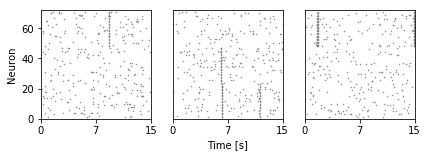

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(6.7,2))

L0, sorted_ind, _, _ = cluster(Ws[samples[0]].copy())

for i, sample in enumerate(samples):
    n,s = np.nonzero(activities[i][sorted_ind,:])
    axs[i].plot(s,n, marker='.', markersize=1, linestyle='none', color = 'gray')
    axs[i].set_ylim(0,N)
    axs[i].set_xlim(0, record_steps)
    axs[i].set_xticklabels([str(int(step*step_time)) for step in axs[i].get_xticks()])
    if i !=0:
        axs[i].set_yticks([])
        
axs[1].set_xlabel('Time [s]')
axs[0].set_ylabel('Neuron')    
plt.show()